# Chapter 14: Regression Diagnostics and Structure

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Diagnostics

In [2]:
np.random.seed(987654321)
x = np.random.uniform(1,100, size=500)
y = 250 + x + np.random.normal(loc=0, scale=10, size=500)
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    249.119728
x              1.042288
dtype: float64

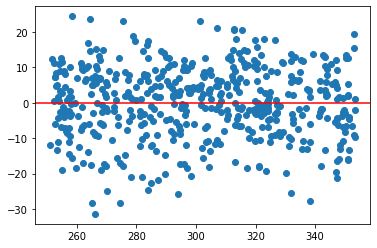

In [3]:
plt.scatter(reg1.fittedvalues, reg1.resid)
plt.axhline(0, color='red')
plt.show()

## Heteroscedasticity

In [4]:
np.random.seed(987654321)
x = np.random.uniform(1,20, size=500)
y = 100 + 2*x + x*np.random.normal(size=500)
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    98.784781
x             2.303887
dtype: float64

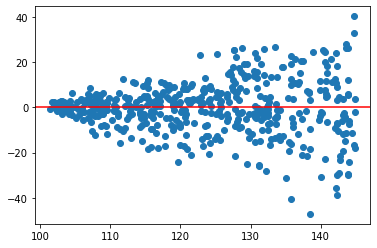

In [5]:
plt.scatter(reg1.fittedvalues, reg1.resid)
plt.axhline(0, color='red')
plt.show()

***logistic regression***

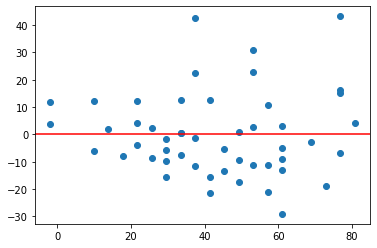

0.6510793807582509

In [6]:
cars = pd.read_csv("../data/cars.csv")
reg2 = ols("dist ~ speed", data=cars).fit()
plt.scatter(reg2.fittedvalues, reg2.resid)
plt.axhline(0, color='red')
plt.show()

reg2.rsquared

In [7]:
reg2.params

Intercept   -17.579095
speed         3.932409
dtype: float64

***Bresuch-Pagan test***

In [8]:
from statsmodels.compat import lzip
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']

In [9]:
test1 = sm.stats.diagnostic.het_breuschpagan(reg1.resid, reg1.model.exog)
lzip(names, test1)

[('Lagrange multiplier statistic', 94.5833482166779),
 ('p-value', 2.3498677853334443e-22),
 ('f-value', 116.18296191020761),
 ('f p-value', 1.7179132159423896e-24)]

In [10]:
test2 = sm.stats.diagnostic.het_breuschpagan(reg2.resid, reg2.model.exog)
lzip(names, test2)

[('Lagrange multiplier statistic', 3.214879927174641),
 ('p-value', 0.07297154505407806),
 ('f-value', 3.2983614504820826),
 ('f p-value', 0.07559716486053959)]

***Box Cox transformation***

In [11]:
fitted_data1, fitted_lambda1 = scipy.stats.boxcox(y)
fitted_lambda1

-1.5741315427789888

In [12]:
fitted_data2, fitted_lambda2 = scipy.stats.boxcox(cars.dist)
fitted_lambda2

0.4950761909055122

***N/A***

## Extreme Values

In [13]:
np.random.seed(987654321)
x = np.random.uniform(low=1, high=100, size=(500,))
y = 250 + x + np.random.normal(loc=0,scale=10,size=(500,))
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    249.119728
x              1.042288
dtype: float64

In [14]:
x[499]=860
df = pd.DataFrame({'x':x, 'y':y})
reg1 = ols("y~x", data=df).fit()
reg1.params

Intercept    278.441160
x              0.439657
dtype: float64

In [15]:
cd = reg1.get_influence().cooks_distance
cutof = 4/500




In [16]:
admit = pd.read_csv("../data/admit.csv")

In [17]:
breg1=sm.formula.glm("admit~gre+gpa+rank", data=admit, family=sm.families.Binomial()).fit()
breg1.params

Intercept   -3.449548
gre          0.002294
gpa          0.777014
rank        -0.560031
dtype: float64